In [1]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import regularizers,layers

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train= pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', header=None)

In [4]:
train.rename(columns = {0: "intent", 5:"text"},  inplace=True)

In [5]:
train['intent']=train['intent'].replace([0,4],[0,1])

In [6]:
train = train.drop([1],axis=1)
train = train.drop([2],axis=1)
train = train.drop([3],axis=1)
train = train.drop([4],axis=1)

In [7]:
train = train.sample(len(train))

In [8]:
data = np.array(train)

In [9]:
allurl_fea = [d[0] for d in data]

In [10]:
test=data[:int(0.001*len(allurl_fea))]

In [11]:
test=pd.DataFrame(test,columns=['intent','text'])

In [12]:
train.index = range(len(train))

In [13]:
train

,intent,text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem
...,...,...
1599995,0,this song's middle change just doesn't want to...
1599996,1,@officialnjonas Good luck with that
1599997,0,@ProudGamerTweet I rather average 32370
1599998,0,Pickin up @misstinayao waitin on @sadittysash ...


C:\Users\86188\anaconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


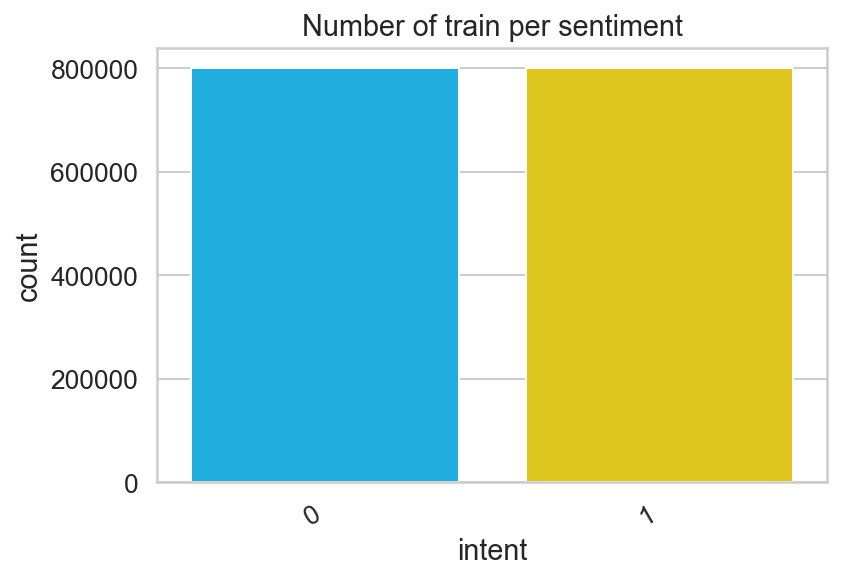

In [14]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF", "#817936"]
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of train per sentiment")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [15]:
os.makedirs("model", exist_ok=True)

In [16]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [17]:
#function 的输入叫“argument”
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    # map(function, input) e.g. input:x,function = x**2, x= [2,3]
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    #print (train.head)
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = [0] * (self.max_seq_len - len(input_ids)) + input_ids
      x.append(np.array(input_ids))
    return np.array(x)

In [18]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [19]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

 
  cls_out = keras.layers.Bidirectional(LSTM(units=69, dropout=0.5, recurrent_dropout = 0.5, return_sequences=True))(bert_output)
  cls_out = keras.layers.LSTM(units=138, dropout=0.5, recurrent_dropout = 0.5, return_sequences=False)(cls_out)
  cls_out = keras.layers.Dense(138, activation='relu',kernel_regularizer=regularizers.l1(1e-3))(cls_out)
  cls_out = keras.layers.Dropout(0.5)(cls_out)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(cls_out)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [20]:
classes = train.intent.unique().tolist()

In [21]:
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=49)

1600000it [07:34, 3522.86it/s]
C:\Users\86188\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
1600it [00:00, 3534.31it/s]


max seq_len 230


In [22]:
train.shape

(1600000, 2)

In [23]:
data.train_x.shape

(1600000, 49)

In [24]:
data.train_x[6700]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   101,  6300, 11057,  1012,
        8840,  2140,  1012,   102])

In [25]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 49, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000028910586FD0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 49)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 49, 768)           108890112 
_________________________________________________________________
bidirectional (Bidirectional (None, 49, 138)           462576    
_________________________________________________________________
lstm_1 (LSTM)                (None, 138)               152904    
_________________________________________________________________
dense (Dense)                (None, 138)               19182     
_________________________________________________________________
dropout (Dropout)            (None, 138)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 278   

In [27]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [28]:
# 建立一个权重的存储点
path_checkpoint  = 'lr_{}.hdf5'.format('Twitter5')
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [29]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [30]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [31]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [32]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('logs', current_time)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.2,
  batch_size= 16,
  shuffle=True,
  epochs=20,
  callbacks=callbacks
)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/20
1279984/1280000 [============================>.] - ETA: 0s - loss: 0.4574 - acc: 0.8628
Epoch 00001: val_loss improved from inf to 0.48738, saving model to lr_Twitter5.hdf5
1280000/1280000 [==============================] - 35429s 28ms/sample - loss: 0.4574 - acc: 0.8628 - val_loss: 0.4874 - val_acc: 0.8269
Epoch 2/20
1279984/1280000 [============================>.] - ETA: 0s - loss: 0.4377 - acc: 0.8797
Epoch 00002: val_loss improved from 0.48738 to 0.48576, saving model to lr_Twitter5.hdf5
1280000/1280000 [==============================] - 35345s 28ms/sample - loss: 0.4377 - acc: 0.8797 - val_loss: 0.4858 - val_acc: 0.8281
Epoch 3/20
1279984/1280000 [============================>.] - ETA: 0s - loss: 0.4257 - acc: 0.8910
Epoch 00003: val_loss improved from 0.48576 to 0.48083, saving model to lr_Twitter5.hdf5
1280000/1280000 [==============================] - 35357s 28ms/sample - loss: 0.4257 - acc: 0.8910 - val_loss: 0.48